In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors
from numpy.random import rand
from scipy.optimize import curve_fit

## Creating a Proper Motion Diagram

In [2]:
#proper motion equation function inputs:
# r = proper_motion_ra
# d = proper_motion_dec
def mu(r,d): 
    mu = np.sqrt(r**2 + d**2)
    return mu

#reduced proper motion equation function inputs:
#mu = proper motion
#gmag = g magnitude
def H(mu,gmag):
    H = 5 + 5*np.log10(mu) + gmag
    return H

#Ratio of reduced proper motion error function inputs:
# r = proper_motion_ra
# er = error in proper_motion_ra
# d = proper_motion_dec
# ed = error in proper_motion_dec
# egmag = error in g magnitude
# gmag = g magnitude
def Herr_over_H(r,er,d,ed,egmag,gmag):
    mu_v = mu(r,d)
    H_err = np.sqrt((5/np.log(10))**2 * (r**2 * er**2 + d**2 * ed**2) / (mu_v**4 + egmag**2))
    H_v = H(mu_v,gmag)
    return H_err/H_v

In [3]:
#Retreiving D6 Star Data from Shen et al. (2018): Reference [1] in README
## note: Gaia is used for proper motion data,
## D6-1 is out of range for PanSTARR, so i magnitudes, et. is found using Skymapper

#Gaia Data for D6 Stars
D6Gaia = pd.read_csv('D6stars.csv')
D6Gaia["parallax"] = D6Gaia["parallax"] / 1000
D6Gaia["proper motion"] = mu(D6Gaia["pmra"],D6Gaia["pmdec"])/1000
D6Gaia["reduced proper motion"] = H(D6Gaia["proper motion"],D6Gaia["phot_g_mean_mag"])

#PanSTARR Data for D6 Stars 
D6PS = pd.read_csv('PS_D6stars1.csv')
D6PS["g-r"] = D6PS["gmag"] - D6PS["rmag"]
D6PS["g-i"] = D6PS["gmag"] - D6PS["imag"]
D6PS["reduced proper motion"] = [0]*2
D6PS["reduced proper motion"][0] += D6PS["gmag"][0] + 5*np.log10(D6Gaia["proper motion"][1]) + 5
D6PS["reduced proper motion"][1] += D6PS["gmag"][1] + 5*np.log10(D6Gaia["proper motion"][2]) + 5

#Skymapper data for D6-1 Star
d61_rmag = 17.433
d61_gmag = 17.607
d61_imag = 17.4749
d61_gr = d61_gmag - d61_rmag
d61_gi = d61_gmag - d61_imag
d6_H1 = d61_gmag + 5*np.log10(D6Gaia["proper motion"][0]) + 5

C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
# Reading WD Cooling Sequence Data for Hydrogen-and Helium- atmosphere WD; Reference [3] in README
#with masses = [0.2, 0.6, 1.3]
table02H = pd.read_csv('Table_Mass_0.2H',sep='\s+') #
table02He = pd.read_csv('Table_Mass_0.2He',sep='\s+')
table06H = pd.read_csv('Table_Mass_0.6',sep='\s+') 
table06He = pd.read_csv('Table_Mass_0.6He',sep='\s+')
table13H = pd.read_csv('Table_Mass_1.3H',sep='\s+')
table13He = pd.read_csv('Table_Mass_1.3He',sep='\s+')

In [5]:
table13H.columns #checking that the columns are correct

Index(['Teff', 'logg', 'Mbol', 'BC', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'Ks',
       'Y', 'J.1', 'H.1', 'K', 'W1', 'W2', 'W3', 'W4', 'S3.6', 'S4.5', 'S5.8',
       'S8.0', 'u', 'g', 'r', 'i', 'z', 'g.1', 'r.1', 'i.1', 'z.1', 'y', 'G',
       'G_BP', 'G_RP', 'FUV', 'NUV', 'Age'],
      dtype='object')

In [6]:
#converting tranverse velocity to proper motion
vt100 = 100*0.210805  
vt300 = 300*0.210805
vt1000 = 1000*0.21080 

In [7]:
#For WD Cooling Sequence Data, df
def WD(df):   
    df["g-i"] = df["g.1"] - df["i.1"]
    df["g-r"] =  df["g.1"] - df["r.1"]
    df["r-z"] = df["r.1"] - df["z.1"]
    df["r-i"] = df["r.1"] - df["i.1"]
    df["i-z"] = df["i.1"] - df["z.1"]
    #Calculating reduce proper motion for different transverse velocities
    df["rpm_100"] = df["g.1"] + 5*np.log10(vt100) 
    df["rpm_1000"] = df["g.1"] + 5*np.log10(vt1000)
    df["rpm_300"] = df["g.1"] + 5*np.log10(vt300)
    return df

In [8]:
#WD Cooling Sequence (these are all data frames)
H06 = WD(table06H)
He06 = WD(table06He)
H02 = WD(table02H)
He02 = WD(table02He)
H13 = WD(table13H)
He13 = WD(table13He)

In [9]:
#reduced proper motion (rpm) diagram function inputs:
# df = GPS1 data (pd.DataFrame)
# caption = caption/txt underneath plot (str)
# title = plt.savefig(title) (str)
def rpm_diagram(df, caption, title): 
    df["pmra"] = df["pmra"] * 3600      #converting units to arcseconds per year
    df["e_pmra"] = df["e_pmra"] * 3600
    df["pmde"] = df["pmde"] * 3600
    df["e_pmde"] = df["e_pmde"] * 3600
    df["g-i"] = df["magg"]-df["magi"]
    df["proper motion"] = mu(df["pmra"], df["pmde"])
    df["reduced proper motion"] = H(df["proper motion"], df["magg"])
    df["error_over_rpm"] = Herr_over_H(df["pmra"], df["e_pmra"], df["pmde"], df["e_pmde"], df["e_magg"], df["magg"])
    
#     #use to double check query parameters and error ratio
#     print("max(H_err/H) = ",np.round(max(df["error_over_rpm"]),4))
#     print("min(mu),max(mu)=",np.round(min(df["proper motion"]),4),',',np.round(max(df["proper motion"]),4),'arcseconds per year')
#     print("max,min of gmag:", np.round(max(df["magg"]),4),",",np.round(min(df["magg"]),4))
#     print("max(g-i):",np.round(max(df["g-i"]),4))
#     print("Length of data:",len(df["g-i"]))
#     print("max H:", np.round(max(df["reduced proper motion"]),4))
    
    fig = plt.figure(figsize=(6,6))
    # plot main data frame
    plt.scatter(df["g-i"],df["reduced proper motion"],c='k',s=0.5)
    plt.hist2d(df["g-i"],df["reduced proper motion"],bins=100,cmin=2) #2d density plot
    # plot D6 Stars for reference
    plt.plot(d61_gi,d6_H1, '.', c='r')
    plt.annotate('D6-1',(d61_gi,d6_H1), textcoords="offset points", xytext=(5,0),ha='left',fontsize=10)
    plt.plot(D6PS["g-i"][0],D6PS["reduced proper motion"][0],'.',c='r')
    plt.annotate('D6-2',(D6PS["g-i"][0],D6PS["reduced proper motion"][0]), textcoords="offset points", xytext=(5,5),ha='right', fontsize=10)
    plt.plot(D6PS["g-i"][1],D6PS["reduced proper motion"][1],'.',c='r')
    plt.annotate('D6-3',(D6PS["g-i"][1],D6PS["reduced proper motion"][1]), textcoords="offset points", xytext=(5,5),ha='right', fontsize=10)
    
    plt.title('GPS1 Reduced Proper Motion Diagram')
    plt.xlabel("g - i", size = 15)
    plt.ylabel("H", size = 15)
    plt.figtext(0.5, -.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    
    #WD Cooling Sequence (these are all data frames)
    H06 = WD(table06H)
    He06 = WD(table06He)
    H02 = WD(table02H)
    He02 = WD(table02He)
    H13 = WD(table13H)
    He13 = WD(table13He)
    
    #Plotting Cooling Sequences for Hydrogen
    #WD Cooling Sequences with transverse velocities of 100 km/s
    plt.plot(H13["g-i"],H13["rpm_100"],label='M=1.3:vt=100km/s',c='r')    
    plt.plot(H06["g-i"],H06["rpm_100"],label='M=0.6:vt=100km/s',c='b')
    plt.plot(H02["g-i"],H02["rpm_100"],label='M=0.2:vt=100km/s',c='g')
    #WD Cooling Sequences with transverse velocities of 1000 km/s
    plt.plot(H13["g-i"],H13["rpm_1000"],label='M=1.3:vt=1000km/s',c='y')
    plt.plot(H06["g-i"],H06["rpm_1000"],label='M=0.6:vt=1000km/s',c='c')
    plt.plot(H02["g-i"],H02["rpm_1000"],label='M=0.2:vt=1000km/s',c='orange')
    #WD Cooling Sequences with transverse velocities of 300 km/s
    plt.plot(H13["g-i"],H13["rpm_300"],c='m', label='M=1.3:vt=300km/s')
    plt.plot(He13["g-i"],He13["rpm_300"],c='m', linestyle='--')
    
    #Plotting Cooling Sequences for Helium
    plt.plot(He06["g-i"],He06["rpm_100"], linestyle='--',c='b')
    plt.plot(He02["g-i"],He02["rpm_100"],linestyle='--',c='g')
    plt.plot(He13["g-i"],He13["rpm_100"],linestyle='--',c='r')
    plt.plot(He06["g-i"],He06["rpm_1000"], linestyle='--',c='c')
    plt.plot(He02["g-i"],He02["rpm_1000"],linestyle='--',c='m')
    plt.plot(He13["g-i"],He13["rpm_1000"],linestyle='--',c='y')
    
    plt.xlim(-1,2)
    plt.ylim(10,30)
    plt.gca().invert_yaxis()
    plt.legend(title='WD Cooling Sequences')
    plt.colorbar()
    plt.savefig(title,bbox_inches="tight")
    plt.show()

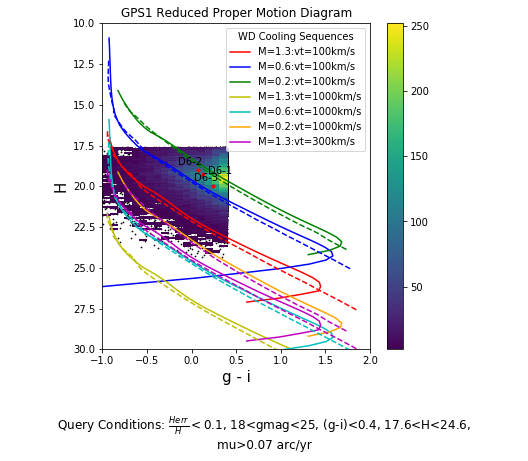

In [10]:
# Query used to create table (23) in GPS1 Proper Motion Catalog; Reference [2] in README
## SELECT TOP 250000 obj_id, ra, dec, e_ra, e_dec, pmra, e_pmra, pmde, e_pmde, magg, magr, e_magg, magi, e_magi,magz, e_magz
## FROM gps1.main
## WHERE magg BETWEEN 18 and 25 
## AND (magg-magi)<0.4 
## AND (SQRT(POWER(pmra*3600,2)+POWER(pmde*3600,2)))>0.07
## AND ((POWER(5/LOG(10),2)*(POWER(pmra*3600,2)*POWER(e_pmra*3600,2)+POWER(pmde*3600,2)*POWER(e_pmde*3600,2))/((POWER(pmra*3600,4)+POWER(pmra*3600,2)*POWER(pmde*3600,2)*2 + POWER(pmde*3600,4))+POWER(e_magg,2)))/POWER(5+5*LOG10(SQRT(POWER(pmra*3600,2)+POWER(pmde*3600,2)))+magg,2))<.01 
## AND (5+5*LOG10(SQRT(POWER(pmra*3600,2)+POWER(pmde*3600,2)))+magg) BETWEEN 17.6 and 24.6

df1 = pd.read_csv('GPS1_Query_Data.csv')
a = rpm_diagram(df1, r'Query Conditions: $\frac{Herr}{H}<0.1$, 18<gmag<25, (g-i)<0.4, 17.6<H<24.6, mu>0.07 arc/yr', 'PM_Diagram_Updated.png')

# Selecting Query Data Under M=1.3, vt=100 km/s Track

In [11]:
#looking at data points below the WD Cooling Sequence with M=1.3 and transverse velocity 100
## I only want data where the evolutionary track passes
H13_filtered = H13.query("rpm_100 < 23 & rpm_100 > 17.5 ")
He13_filtered = He13.query("rpm_100 < 23 & rpm_100 > 17.5 ")

In [12]:
#creating a best cubic fit in order to find the data points below the track
def WD_fit_func(x,a, b, c, d):
    y = a * x**3 + b*x**2 + c*x +d
    return y

1-param =  2.7338 +/- 0.5314
2-param =  0.9541 +/- 0.5579
3-param =  3.2764 +/- 0.1377
4-param =  21.8519 +/- 0.0418


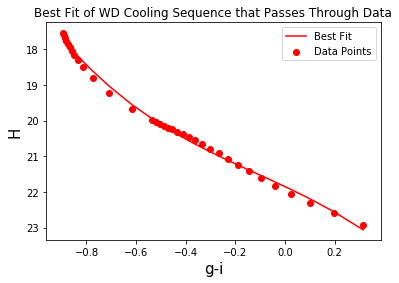

In [13]:
# For Hydrogen
#popt = parameters
#pcov = covariance matrix
popt, pcov = curve_fit(WD_fit_func, H13_filtered["g-i"], H13_filtered["rpm_100"])
perr = np.sqrt(np.diag(pcov)) #parameter uncertainty
for i in range(len(popt)):
    print(str(i+1)+'-param = ', round(popt[i],4), '+/-', round(perr[i],4))

# For Helium
popthe, pcovhe = curve_fit(WD_fit_func, He13_filtered["g-i"], He13_filtered["rpm_100"])

f = WD_fit_func(H13_filtered["g-i"],*popt) #Expected Points for hydrogen
fe = WD_fit_func(He13_filtered["g-i"],*popt) #Expected Points for helium
plt.scatter(H13_filtered["g-i"], H13_filtered["rpm_100"],c='r',label='Data Points')
plt.plot(H13_filtered["g-i"],f,c='r',label='Best Fit') #
plt.gca().invert_yaxis()
plt.title('Best Fit of WD Cooling Sequence that Passes Through Data')
plt.ylabel('H', size=15)
plt.xlabel('g-i',size=15)
plt.legend()
plt.show()

In [14]:
#creating column with expected reduced proper motion values from best fit
df1["f for rpm_100"] = WD_fit_func(df1["g-i"],*popt)
#filtering the points below the fit
df1_filtered = df1[df1["reduced proper motion"] > df1["f for rpm_100"]]

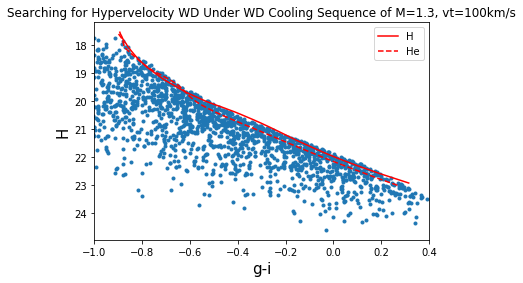

In [15]:
plt.plot(df1_filtered["g-i"],df1_filtered["reduced proper motion"],'.')
plt.plot(H13_filtered["g-i"],H13_filtered["rpm_100"],label='H',c='r')
plt.plot(He13_filtered["g-i"],He13_filtered["rpm_100"],linestyle='--',label='He',c='r')
plt.gca().invert_yaxis()
plt.title('Searching for Hypervelocity WD Under WD Cooling Sequence of M=1.3, vt=100km/s')
plt.ylabel('H',size=15)
plt.xlabel('g-i',size=15)
plt.xlim(-1,0.4)
plt.legend()
plt.show()

In [16]:
total_under_curve100 = len(df1_filtered)
total_under_curve100

2428

# Creating Color-Color Diagrams for Data Below Track (M=1.3, vt=100km/s)

In [17]:
## creating color-color diagrams for the filtered set above to differentiate between WD's (>100 km/s) and  
## really old blue stars. 
#df1_filtered.columns
df1_filtered["r-i"] = df1_filtered["magr"] - df1_filtered["magi"]
df1_filtered["g-r"] = df1_filtered["magg"] - df1_filtered["magr"]
df1_filtered["i-z"] = df1_filtered["magi"] - df1_filtered["magz"]

C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [18]:
df1_filtered.columns

Index(['obj_id', 'ra', 'dec', 'e_ra', 'e_dec', 'pmra', 'e_pmra', 'pmde',
       'e_pmde', 'magg', 'magr', 'e_magg', 'magi', 'e_magi', 'magz', 'e_magz',
       'g-i', 'proper motion', 'reduced proper motion', 'error_over_rpm',
       'f for rpm_100', 'r-i', 'g-r', 'i-z'],
      dtype='object')

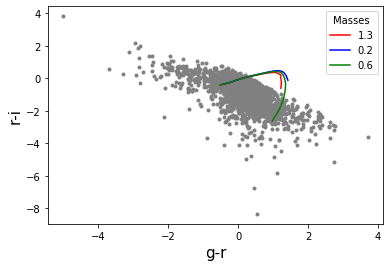

In [19]:
#looking at (r-i) vs (g-r)
plt.plot(df1_filtered["g-r"],df1_filtered["r-i"],'.',c='grey')
plt.plot(H13["g-r"],H13["r-i"], c='r', label='1.3')
plt.plot(H02["g-r"],H02["r-i"],c='b', label='0.2')
plt.plot(H06["g-r"],H06["r-i"],c='g',label='0.6')
plt.xlabel("g-r", size=15)
plt.ylabel("r-i", size=15)
plt.legend(title='Masses')
plt.show()
#plt.gca().invert_yaxis()

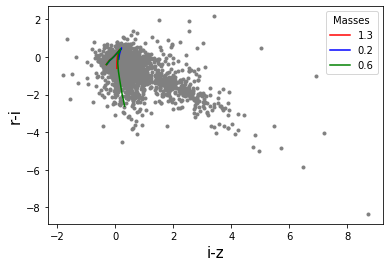

In [20]:
#looking at (r-i) vs. (i-z)
plt.plot(df1_filtered["i-z"],df1_filtered["r-i"],'.',c='grey')
plt.plot(H13["i-z"],H13["r-i"], c='r',label='1.3')
plt.plot(H02["i-z"],H02["r-i"],c='b',label='0.2')
plt.plot(H06["i-z"],H06["r-i"],c='g',label='0.6')
plt.xlabel("i-z", size=15)
plt.ylabel("r-i", size=15)
plt.legend(title='Masses')
#plt.gca().invert_yaxis()

In [21]:
# capturing too many data points: trying to limit data to below the M=1.3 at vt = 300 km/s

# Selecting Query Data Under M=1.3, vt=300 km/s Track

1-param =  2.7338 +/- 0.5314
2-param =  0.9541 +/- 0.5579
3-param =  3.2764 +/- 0.1377
4-param =  24.2375 +/- 0.0418


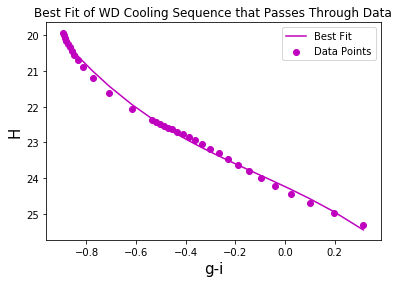

In [22]:
#repeating best fit for track at M=1.3 and vt = 300 
# For Hydrogen
popt300, pcov300 = curve_fit(WD_fit_func, H13_filtered["g-i"], H13_filtered["rpm_300"])
perr300 = np.sqrt(np.diag(pcov)) #parameter uncertainty
for i in range(len(popt300)):
    print(str(i+1)+'-param = ', round(popt300[i],4), '+/-', round(perr300[i],4))

# For Helium
popthe300, pcovhe300 = curve_fit(WD_fit_func, He13_filtered["g-i"], He13_filtered["rpm_300"])

f = WD_fit_func(H13_filtered["g-i"],*popt300) #Expected Points for hydrogen
fe = WD_fit_func(He13_filtered["g-i"],*popthe300) #Expected Points for helium
plt.scatter(H13_filtered["g-i"], H13_filtered["rpm_300"],c='m',label='Data Points')
plt.plot(H13_filtered["g-i"],f,c='m',label='Best Fit') #
plt.gca().invert_yaxis()
plt.title('Best Fit of WD Cooling Sequence that Passes Through Data')
plt.ylabel('H', size=15)
plt.xlabel('g-i',size=15)
plt.legend()
plt.show()

C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\fatim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

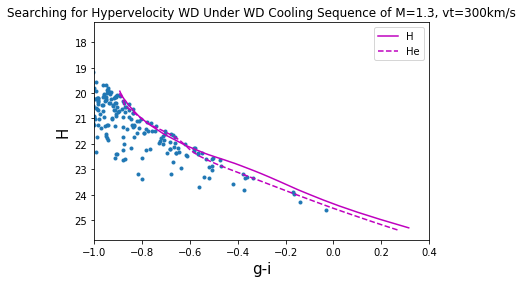

In [23]:
#creating column with expected reduced proper motion values from best fit
df1["f for rpm_300"] = WD_fit_func(df1["g-i"],*popt300)
#filtering the points below the fit
df2_filtered = df1[df1["reduced proper motion"] > df1["f for rpm_300"]]
df2_filtered["r-i"] = df2_filtered["magr"] - df2_filtered["magi"]
df2_filtered["g-r"] = df2_filtered["magg"] - df2_filtered["magr"]
df2_filtered["i-z"] = df2_filtered["magi"] - df2_filtered["magz"]


plt.plot(df2_filtered["g-i"],df2_filtered["reduced proper motion"],'.')
plt.plot(H13_filtered["g-i"],H13_filtered["rpm_300"],label='H',c='m')
plt.plot(He13_filtered["g-i"],He13_filtered["rpm_300"],linestyle='--',label='He',c='m')
plt.gca().invert_yaxis()
plt.title('Searching for Hypervelocity WD Under WD Cooling Sequence of M=1.3, vt=300km/s')
plt.ylabel('H',size=15)
plt.xlabel('g-i',size=15)
plt.xlim(-1,0.4)
plt.legend()
plt.show()

In [24]:
total_under_curve300 = len(df2_filtered)
total_under_curve300

892

# Creating Color-Color Diagrams for Data Below Track (M=1.3, vt=300km/s)

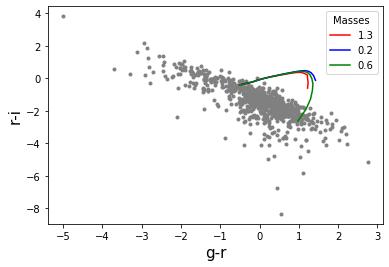

In [25]:
#looking at (r-i) vs (g-r)
plt.plot(df2_filtered["g-r"],df2_filtered["r-i"],'.',c='grey')
plt.plot(H13["g-r"],H13["r-i"], c='r', label='1.3')
plt.plot(H02["g-r"],H02["r-i"],c='b', label='0.2')
plt.plot(H06["g-r"],H06["r-i"],c='g',label='0.6')
plt.xlabel("g-r", size=15)
plt.ylabel("r-i", size=15)
plt.legend(title='Masses')
plt.show()

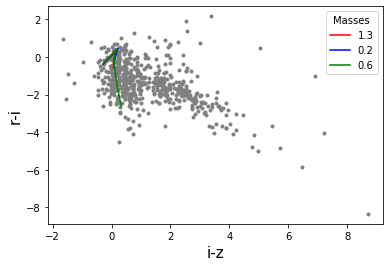

In [26]:
#looking at (r-i) vs. (i-z)
plt.plot(df2_filtered["i-z"],df2_filtered["r-i"],'.',c='grey')
plt.plot(H13["i-z"],H13["r-i"], c='r',label='1.3')
plt.plot(H02["i-z"],H02["r-i"],c='b',label='0.2')
plt.plot(H06["i-z"],H06["r-i"],c='g',label='0.6')
plt.xlabel("i-z", size=15)
plt.ylabel("r-i", size=15)
plt.legend(title='Masses')
plt.show()
#plt.gca().invert_yaxis()